In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys 
import commot as ct

sys.path.append('../../src')
sys.path.append('..')

from spaceoracle.tools.network import expand_paired_interactions
from spaceoracle.oracles import BaseTravLR
from spaceoracle.tools.network import encode_labels

import celloracle as co

In [3]:
adata = sc.read_h5ad(
    '/Users/koush/Downloads/slideTCR_asthma_lymphnode_tangramAnno_wTCR_wRegion_sample1.h5ad')

In [6]:
adata.var_names = adata.var_names.str.capitalize()

adata = adata[:, ~adata.var_names.str.contains('Rik')]
adata = adata[:, ~adata.var_names.str.contains('rik')]
adata = adata[:, ~adata.var_names.str.contains(r'^Hb\w+-\w+$')]
adata = adata[:, ~adata.var_names.str.contains('Hp')]
adata = adata[:, ~adata.var_names.str.startswith('Rp')]
adata = adata[:, ~adata.var_names.str.startswith('n-r5s')]
adata = adata[:, ~adata.var_names.str.startswith('n-r5')]
adata = adata[:, ~adata.var_names.str.startswith('N-r5s')]
adata = adata[:, ~adata.var_names.str.startswith('N-r5')]
adata = adata[:, ~adata.var_names.str.startswith('n-R5s')]
adata = adata[:, ~adata.var_names.str.startswith('n-R5')]
adata = adata[:, ~adata.var_names.str.startswith('N-R5s')]
adata = adata[:, ~adata.var_names.str.startswith('N-R5')]
adata = adata[:, ~adata.var_names.str.startswith('Aa')]
adata = adata[:, ~adata.var_names.str.startswith('Ab')]
adata = adata[:, ~adata.var_names.str.startswith('Ac')]
adata = adata[:, ~adata.var_names.str.startswith('Gm')]
adata = adata[:, ~adata.var_names.str.startswith('Mir')]
adata = adata[:, adata.var.index.str.len() > 1]
adata = adata[:, [i for i in adata.var_names if not (i[:2].isupper() and i[:2].isalpha())]]
adata = adata[:, [gene for gene in adata.var_names if not gene[-4:].isdigit()]]

In [6]:
split_tangram = adata.obs.celltype_label_tangram.str.split(r'\s\|\s').explode()
split_tangram.name = 'cell_type'

In [7]:
adata_ = adata[split_tangram.index]
adata_.obs = adata.obs.join(split_tangram)[
    ['celltype_label_tangram', 'cell_type', 'n_counts', 'n_features']]
adata.shape, adata_.shape

((27348, 15319), (35112, 15319))

In [8]:
rules = (
    ((adata_.obs.cell_type=='CD8+ T')&(adata_.obs.celltype_label_tangram==('CD8+ T')) | 
    (adata_.obs.cell_type!='CD8+ T')) &
    ((adata_.obs.cell_type=='Resting T')&(adata_.obs.celltype_label_tangram==('Resting T')) | 
    (adata_.obs.cell_type!='Resting T')) &
    ((adata_.obs.cell_type=='B')&(adata_.obs.celltype_label_tangram==('B')) | 
    (adata_.obs.cell_type!='B')) &
    ((adata_.obs.cell_type=='DC')&(adata_.obs.celltype_label_tangram==('DC')) | 
    (adata_.obs.cell_type!='DC')) &
    (adata_.obs.cell_type!='Unknown') &
    (adata_.obs.cell_type!='gd T') &
    (adata_.obs.cell_type!='NK')
)

In [9]:
adata.obs.celltype_label_tangram.value_counts().loc[['Resting T', 'B', 'CD8+ T', 'DC']]

celltype_label_tangram
Resting T     3781
B            12481
CD8+ T        2082
DC             230
Name: count, dtype: int64

In [10]:
adata_.obs[rules].cell_type.value_counts()

cell_type
B            12481
Resting T     3781
Tfh           2126
CD8+ T        2082
Treg          1791
Th2            640
DC             230
Name: count, dtype: int64

In [11]:
var_names = ['Ccr4', 'Foxp3', 'Cd8a', 'Il2', 'Il2ra', 'Pax5', 'Bcl6', 
    'Prdm1', 'Cd27', 'Gata3', 'Cd44', 'Cd4', 'Nampt', 'Lgals9', 'Pdcd1', 
    'Havcr2', 'Tnfrsf18', 'Pdcd1lg2', 'Cd274']

In [14]:
%matplotlib inline

In [18]:
ref = sc.read_h5ad('/Users/koush/Downloads/zhongli_ref_202401203_mannually_woDoublet.h5ad')

... storing 'cell_type' as categorical


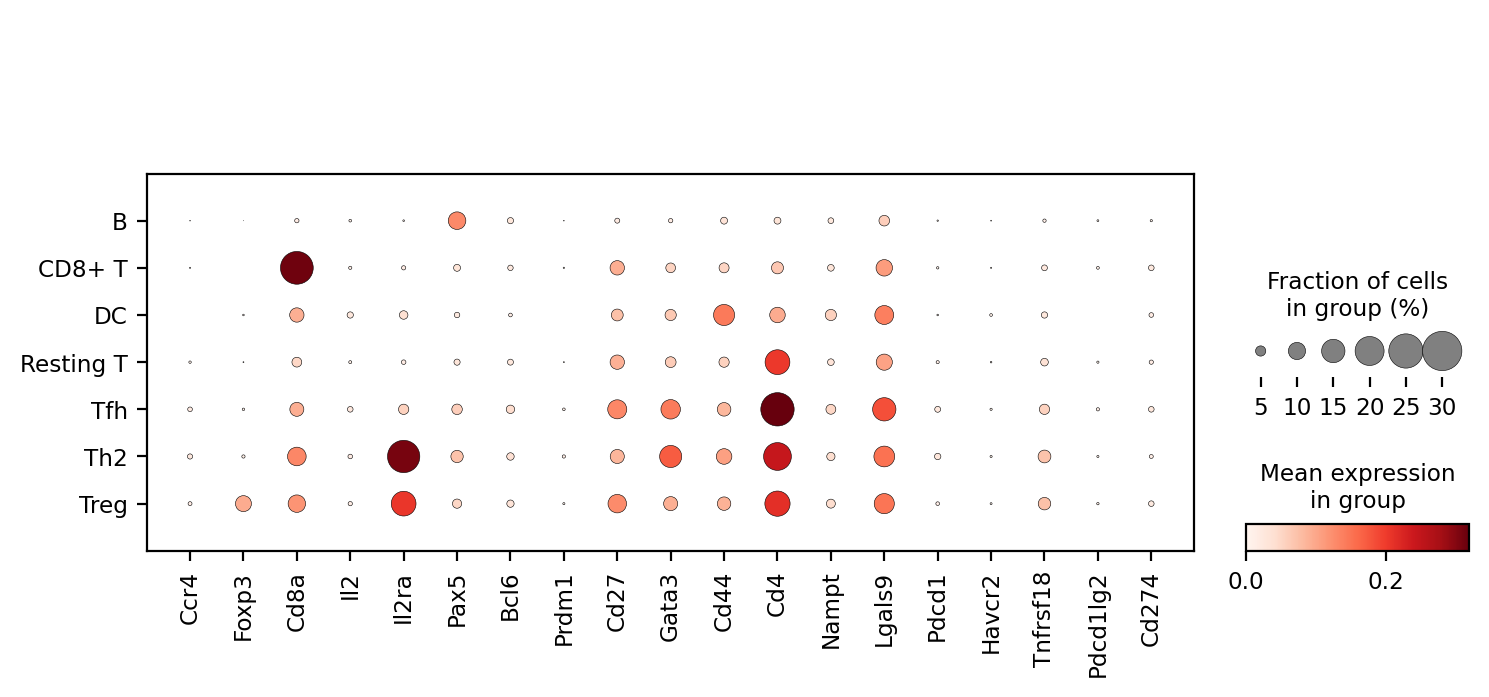

In [16]:
sc.pl.dotplot(adata_[rules], 
    var_names=var_names, swap_axes=False,
    groupby='cell_type')

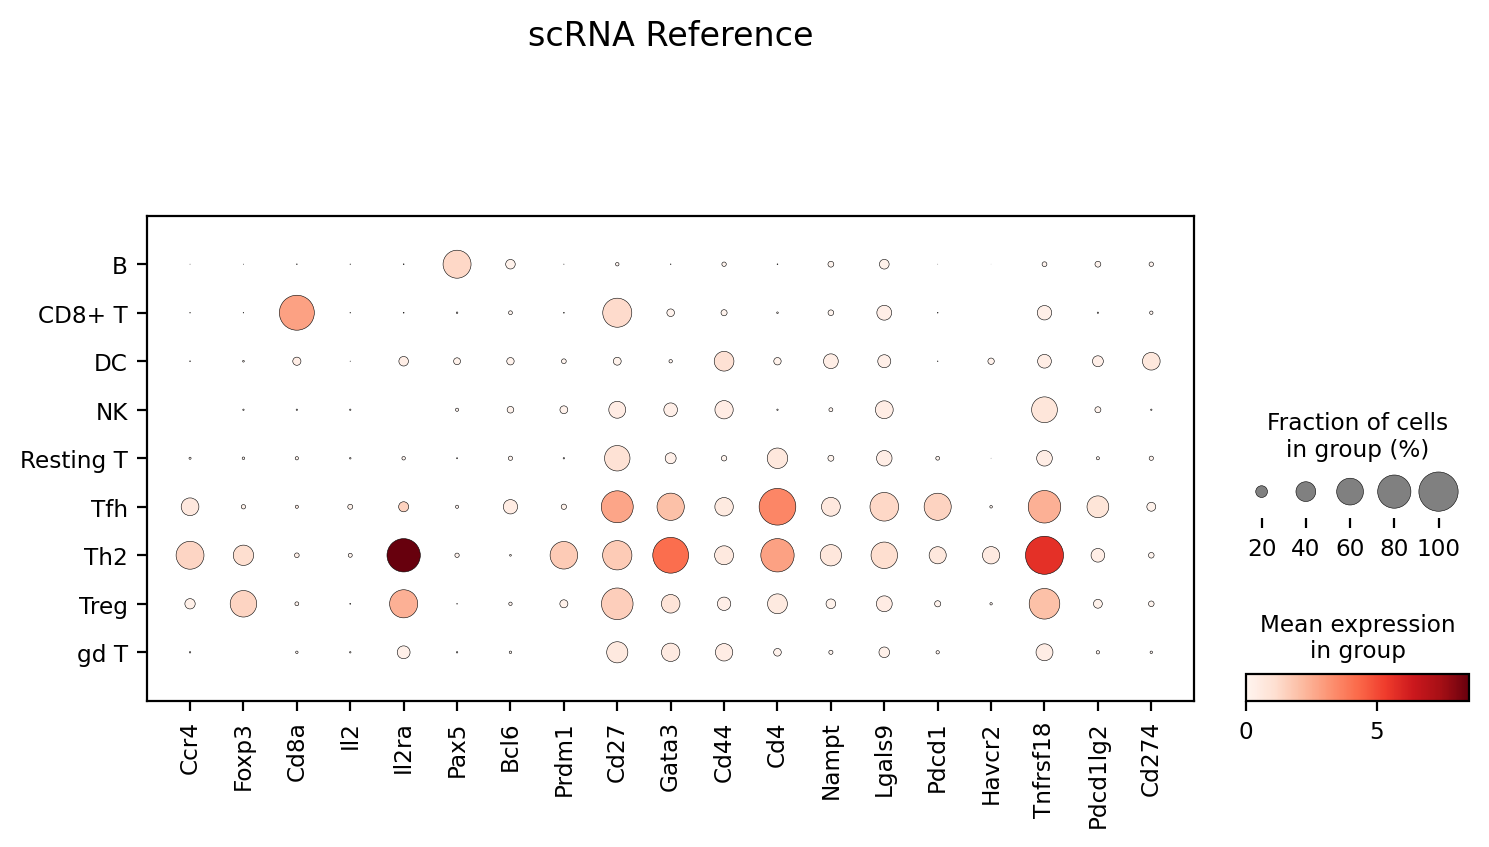

In [19]:
sc.pl.dotplot(ref, 
    var_names=var_names, swap_axes=False,
    groupby='cell_type', title='scRNA Reference')

In [20]:
adata = adata_[rules]

In [22]:
adata.var_names_make_unique()
adata.var["Mt"] = adata.var_names.str.startswith("Mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["Mt"], inplace=True)
adata = adata[adata.obs["pct_counts_Mt"] < 20].copy()
adata = adata[:, ~adata.var["Mt"]]
adata.layers["raw_count"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [23]:
adata = adata[adata.obs.celltype_label_tangram!='Unknown']

In [24]:
adata.obs.celltype_label_tangram = adata.obs.celltype_label_tangram.astype(str)

In [25]:
base_GRN = co.data.load_mouse_promoter_base_GRN()

Loading prebuilt promoter base-GRN. Version: mm10_gimmemotifsv5_fpr2


In [26]:
df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='mouse', 
        signaling_type=None
    )
            
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']
df_ligrec = expand_paired_interactions(df_ligrec)

In [27]:
adata.layers["normalized_count"] = adata.to_df().values.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=3000)
adata.X = adata.layers["raw_count"].copy()
adata

AnnData object with n_obs × n_vars = 22919 × 15296
    obs: 'celltype_label_tangram', 'cell_type', 'n_counts', 'n_features', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mt', 'log1p_total_counts_Mt', 'pct_counts_Mt'
    var: 'n_cells', 'sparsity', 'Mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'final_region_colors', 'overlap_genes', 'training_genes', 'log1p', 'hvg'
    obsm: 'X_spatial', 'spatial', 'tangram_ct_pred'
    layers: 'raw_count', 'normalized_count'

In [28]:
adata.layers["normalized_count"].max()

5.011587

In [29]:
sc.pp.filter_genes(adata, min_counts=1)

In [30]:
adata.obs_names_make_unique()

In [31]:
ligand_receptor_genes = np.intersect1d(
    adata.var_names, 
    df_ligrec.ligand.unique().tolist()+df_ligrec.receptor.unique().tolist())

In [32]:
lr_df = adata.to_df(layer='normalized_count').join(
    adata.obs.cell_type).groupby('cell_type').mean()[
        ligand_receptor_genes].mean().sort_values(ascending=False).to_frame().reset_index()
lr_df.columns = ['genes', 'expr']

In [33]:
lr_df['mean_expr'] = lr_df['genes'].apply(lambda x: adata.to_df(layer='normalized_count')[x].mean())

In [34]:
adata = adata[:, (adata.var.highly_variable | adata.var_names.isin(
    [
        'Cxcl12','Cxcr4', 'Mif', 'Il2', 'Il4', 
        'Il2ra', 'Pax5', 'Bach2', 'Prdm1', 
        'Bcl6', 'Foxp3', 'Gata3', 'Stat2', 'Stat4', 'Ccr4', 'Foxp3', 'Cd8a', 'Il2', 'Il2ra', 'Pax5', 'Bcl6', 
    'Prdm1', 'Cd27', 'Gata3', 'Cd44', 'Cd4', 'Nampt', 'Lgals9', 'Pdcd1', 
    'Havcr2', 'Tnfrsf18', 'Pdcd1lg2', 'Cd274'
    ] + lr_df.query('expr > 0.005').genes.to_list()
))]

In [35]:
adata

View of AnnData object with n_obs × n_vars = 22919 × 3128
    obs: 'celltype_label_tangram', 'cell_type', 'n_counts', 'n_features', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mt', 'log1p_total_counts_Mt', 'pct_counts_Mt'
    var: 'n_cells', 'sparsity', 'Mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_counts'
    uns: 'final_region_colors', 'overlap_genes', 'training_genes', 'log1p', 'hvg'
    obsm: 'X_spatial', 'spatial', 'tangram_ct_pred'
    layers: 'raw_count', 'normalized_count'

In [36]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_int'] = adata.obs['cell_type'].apply(
    lambda x: encode_labels(adata.obs['cell_type'], reverse_dict=True)[x])

In [37]:
adata.obs = adata.obs[['cell_type', 'cell_type_int', 'celltype_label_tangram']]

In [38]:
del adata.uns

In [39]:
adata.var = adata.var.drop(columns=adata.var.columns, inplace=False)

In [40]:
# pcs = BaseTravLR.perform_PCA(adata)
# BaseTravLR.knn_imputation(adata, pcs, method='MAGIC')

In [41]:
adata

AnnData object with n_obs × n_vars = 22919 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    obsm: 'X_spatial', 'spatial', 'tangram_ct_pred'
    layers: 'raw_count', 'normalized_count'

In [42]:
BaseTravLR.impute_clusterwise(adata)

Imputing clusterwise: 100%|██████████| 7/7 [01:13<00:00, 10.45s/it]


In [43]:
adata

AnnData object with n_obs × n_vars = 22919 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    obsm: 'X_spatial', 'spatial', 'tangram_ct_pred'
    layers: 'raw_count', 'normalized_count', 'imputed_count'

In [56]:
adata.write_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')

In [ ]:
# adata_subset = adata[adata.obs.cell_type.isin(['T_CD4'])]
# sc.pp.neighbors(adata_subset, use_rep='X_pca')

# sc.tl.leiden(adata_subset, resolution=0.9)
# adata.obs = adata.obs.join(adata_subset.obs.leiden)

# adata.obs.leiden = adata.obs.leiden.replace({
#     '0': 'Naive CD4 T',
#     '1': 'Treg',
#     '2': 'T memory',
#     '3': 'T memory',
#     '4': 'Th1',
#     '5': 'Th2',
#     '6': 'Treg',
# })

# adata.obs.leiden = adata.obs.leiden.astype(str)
# adata.obs.leiden = adata.obs.leiden.replace('nan', np.nan)
# adata.obs = adata.obs.astype(str)

# adata.obs['cell_type_2'] = adata.obs['leiden'].copy()
# mask_gc = adata.obs['author_cell_type'] == 'B_germinal_center'
# adata.obs.loc[mask_gc, 'cell_type_2'] = adata.obs.loc[mask_gc, 'banksy_celltypes']
# mask_na = adata.obs['cell_type_2'].isin(['nan', 'NA', 'na']) | adata.obs['cell_type_2'].isna()
# adata.obs.loc[mask_na, 'cell_type_2'] = adata.obs.loc[mask_na, 'author_cell_type']

# adata.obs['cell_type_2'] = adata.obs['cell_type_2'].replace({
#     'T_CD4': 'FDC',
# })
# mask = (adata.obs['author_cell_type'] == 'B_germinal_center') & (adata.obs['banksy_celltypes'] == 'T_follicular_helper')
# adata.obs.loc[mask, 'cell_type_2'] = 'B_germinal_center'

# mask = (adata.obs['cell_type_2'] == 'B_germinal_center') & (adata.obs['banksy_celltypes'] == 'T_follicular_helper')
# adata.obs.loc[mask, 'cell_type_2'] = 'T_follicular_helper'
# adata

# adata.obs.iloc[[ 444, 1834, 3626, 3647], 
#                adata.obs.columns.get_loc('cell_type_2')] = 'B_memory'
# adata.obs.iloc[[ 375,  582,  703, 1808, 2609, 4208, 4819], 
#                adata.obs.columns.get_loc('cell_type_2')] = 'T_follicular_helper'
# adata.obs.iloc[[ 1998, 167,  454,  598, 1902, 2003, 2150, 2730, 2820, 3359, 5172, 5231, 5423, 5487, 5603], 
#                adata.obs.columns.get_loc('cell_type_2')] = 'GC Intermediate Zone'
# adata.obs.iloc[[  48,  501,  721,  779,  892, 1275, 1404, 2274, 2881, 3196, 3585, 
#                 4200, 4567, 4823, 4825, 5196, 5441, 5595], 
#                adata.obs.columns.get_loc('cell_type_2')] = 'GC Light Zone'

# adata.obs['cell_type_2'] = adata.obs['cell_type_2'].astype('category')
# adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')

# adata.obs['cell_type_2'].astype('str').to_csv('tonsil_cell_types.csv')